In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn import discriminant_analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, roc_auc_score

In [2]:
class ClassificationModels:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)

    def histograma(self, probabilidades, y_test):
        juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': probabilidades
        })

        plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1')
        plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0')
        plt.title(f'Histograma de probabilidades')
        plt.legend()
        plt.show()
    
    def calibracion(self, probabilidades, bins = 10):
        calibracion = pd.DataFrame({
        'target': self.y_test, 
        'probabilidades': probabilidades
        })

        calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=bins, labels=False) + 1
        grouped = calibracion.groupby('bins').mean()

        plt.plot(grouped.probabilidades, grouped.target, marker="o", c = 'navy')
        plt.plot(grouped.probabilidades, grouped.probabilidades, color="red")
        plt.xlabel("Probabilidad")
        plt.ylabel("Real")
        plt.grid()
        plt.show()

    def logistic_regression(self):
        model = linear_model.LogisticRegression().fit(self.X_train, self.y_train)
        probabilidades = model.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)


        coeficientes = pd.DataFrame({
            'features': self.X.columns,
            'coeficiente': model.coef_[0]
        })
        display(coeficientes)
        self.calibracion(probabilidades)
        self.histograma(probabilidades, self.y_test)
        return auc
    
    def logistic_regression_poly(self, degree=2):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree)),
            ('logistic', linear_model.LogisticRegression(penalty='l2'))
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades)
        self.histograma(probabilidades, self.y_test)
        return auc  

    def discriminant_analysis(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades)
        self.histograma(probabilidades, self.y_test)
        return auc
    
    def knn_classification(self):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        auc = [roc_auc_score(y_score=neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled,self.y_train).predict_proba(X_test_scaled)[:, 1], y_true=self.y_test) for i in range(1,100)]

        knn = pd.DataFrame({
            'nn': range(1,100),
            'auc':auc
        })

        opt_nn = knn[knn['auc']==knn['auc'].max()]['nn'].values[0]
        model = neighbors.KNeighborsClassifier(n_neighbors=opt_nn).fit(X_train_scaled, self.y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:, 1]
        auc = auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)
        
        self.calibracion(probabilidades)
        self.histograma(probabilidades, self.y_test)
        return knn[knn['auc']==knn['auc'].max()]

In [3]:
df = pd.read_csv('alzheimers_disease_data.csv')
df = df.drop(columns=['DoctorInCharge','PatientID'])
df = pd.get_dummies(df, columns=['Ethnicity','EducationLevel'])
df.head()

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,73,0,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,...,0,0,True,False,False,False,False,False,True,False
1,89,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,...,1,0,True,False,False,False,True,False,False,False
2,73,0,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,...,0,0,False,False,False,True,False,True,False,False
3,74,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,...,0,0,True,False,False,False,False,True,False,False
4,89,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,...,0,0,True,False,False,False,True,False,False,False


In [4]:
target = 'Diagnosis'
X = df.copy()
X = X.drop(columns=target)
y = df[target]

models = ClassificationModels(X, y)

## Regresión Logística

,features,coeficiente
0,Age,0.017198
1,Gender,0.134709
2,BMI,-0.018805
3,Smoking,-0.017405
4,AlcoholConsumption,-0.041112
5,PhysicalActivity,-0.029838
6,DietQuality,0.068912
7,SleepQuality,-0.095315
8,FamilyHistoryAlzheimers,-0.023929
9,CardiovascularDisease,0.066169


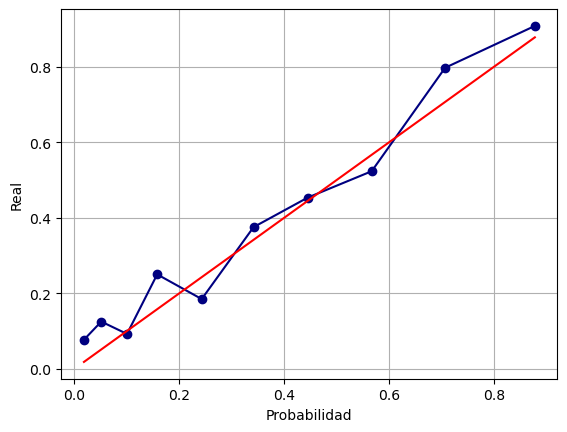

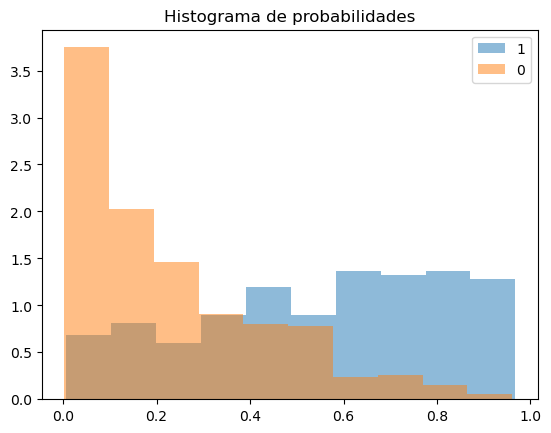

0.8232696946159191

In [5]:
models.logistic_regression()

## Regresión logística polinomial grado 2

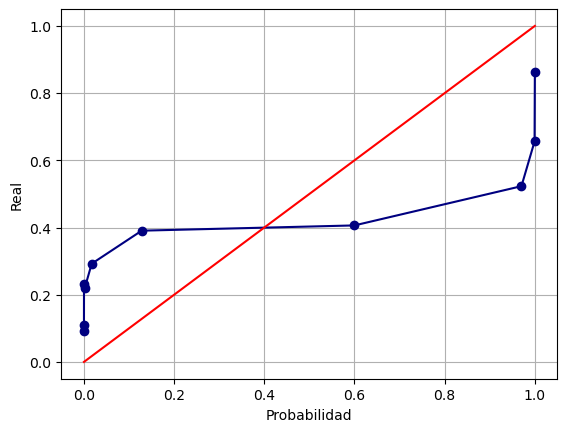

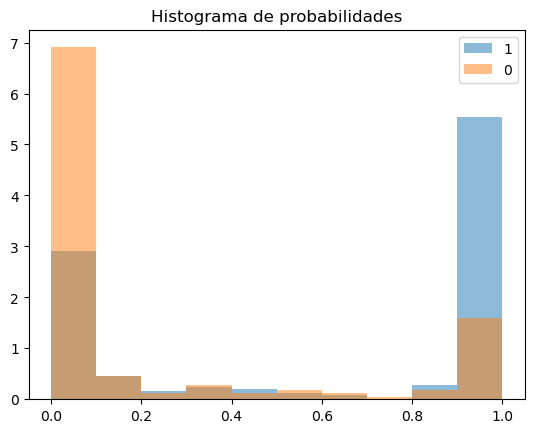

0.7774416417971464

In [6]:
models.logistic_regression_poly(degree=2)

## Regresión logística polinomial grado 3

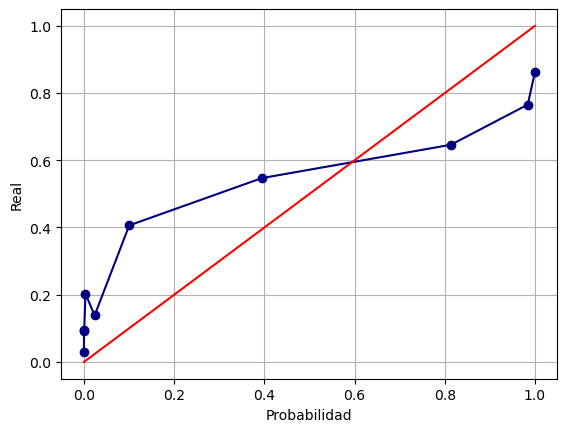

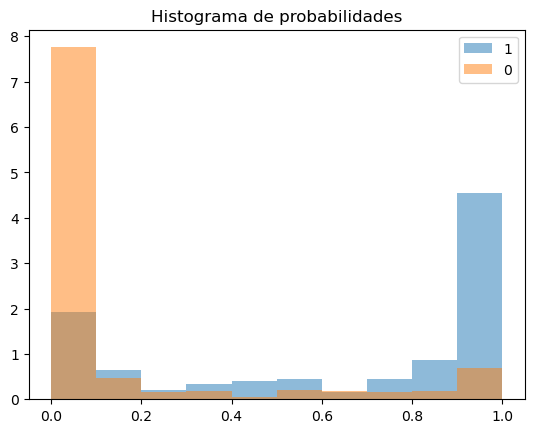

0.8480336045133069

In [7]:
models.logistic_regression_poly(degree=3)

## KNN

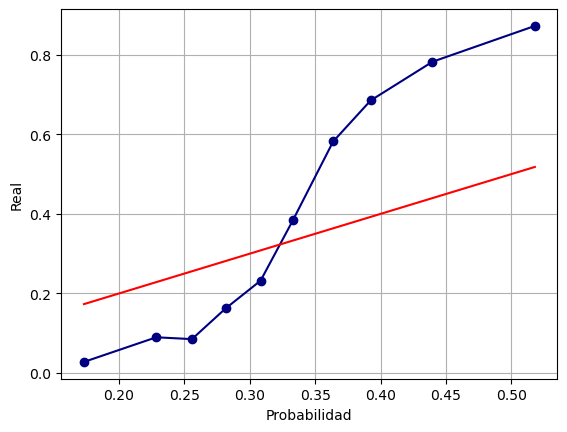

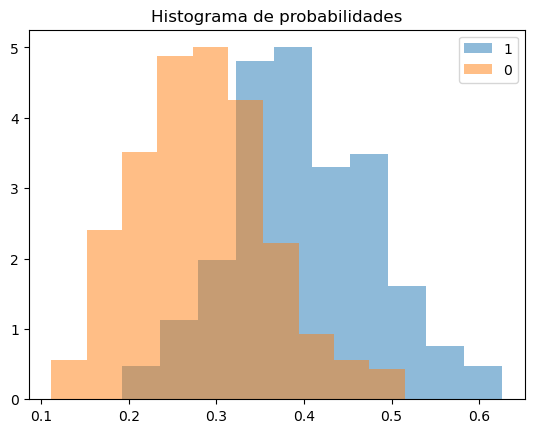

,nn,auc
98,99,0.857406


In [8]:
models.knn_classification()

## Discriminante lineal

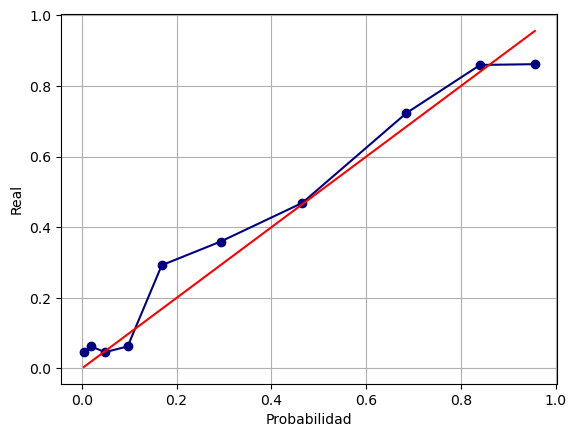

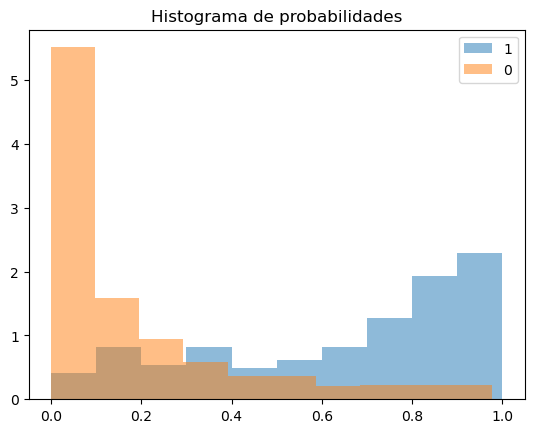

0.8795327255631412

In [9]:
models.discriminant_analysis()